<a href="https://colab.research.google.com/github/giabao804/ML_VIN/blob/main/BiRNN_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Giới thiệu**
### Bi-directional Recurrent Neural Network
Trong bài tập về nhà lần này, chúng ta sẽ xây dựng mạng RNN hai chiều với PyTorch

## **Tổng quan về BiRNN**

<img src="https://www.easy-tensorflow.com/images/NN/03.png" alt="nn" style="width: 600px;"/>

Như các bạn đã biết, mạng RNN gặp trở ngại lớn về việc short-term memory do vấn đề gradient vashing trong quá trình huấn luyện. Vậy nên, mạng Bidirectional RNNs đã được giới thiệu bởi [Schuster and Paliwal, 1997](https://d2l.ai/chapter_references/zreferences.html#id247). Bây giờ chúng ta sẽ xem xét chi tiết mạng này:

Tại timestep t, cho minibatch input $X_t∈R^{n*d}$ (số examples: n, và số input trong mỗi example: d) và cho hàm kích hoạt của lớp ẩn là Φ. Trong kiến trúc hai chiều, giả sử trạng thái ẩn của `forward` và `backward` lần lượt cho timestep này là $\stackrel{→}{H_t} \in R^{n*h}$ và $\stackrel{←}{H_t} \in R^{n*h}$, trong đó *h* là số chiều của lớp ẩn. Trạng thái ẩn của `forward` và `backward` được cập nhật như sau:
$$\stackrel{→}{H_t} = Φ(X_tW_{xh}^{(f)}+\stackrel{→}{H_{t-1}}W_{hh}^{(f)} + b_h^{(f)})$$
$$\stackrel{←}{H_t} = Φ(X_tW_{xh}^{(b)}+\stackrel{←}{H_{t+1}}W_{hh}^{(b)} + b_h^{(b)})$$

trong đó, weights là $W^{(f)}_{xh} \in R^{d*h}, W^{(f)}_{hh} \in R^{h*h}, W^{(b)}_{xh} \in R^{d*h}, W^{(b)}_{hh} \in R^{h*h}$ và biases là $b^{(f)}_h \in R^{1*h}, b^{(b)}_h \in R^{1*h}$ đều là các tham số của model.

Sau đó, chúng ta concatenate trạng thái ẩn của `forward` và `backward` $\stackrel{→}{H_t},\stackrel{\leftarrow}{H_t}$ được $H_t \in R_{n*2h}$ để đưa vào layer cuối. Cuối cùng, layer cuối cùng tính toán output $O_t \in R^{n*q}$ (number of classes: q):
$$O_t = H_tW_{hq} + {b}_q$$

Ở đây, trọng số $W_{hq}∈R^{2h*q}$ và bias $b_q∈R^{1*q}$.


**Các bạn hãy chú ý kích thước của trọng số để điền đúng vào các thông số của mô hình.**





## **Setup**


### Cài đặt bộ dữ liệu MNIST

Ví dụ này sử dụng bộ dữ liệu về chữ số viết tay MNIST. Bộ dữ liệu chữa 60k mẫu cho huấn luyện và 10k mẫu cho kiểm thử.

![MNIST Dataset](https://i1.wp.com/varianceexplained.org/images/mnist.png?w=456)

Để phân loại hình ảnh sử dụng RNN, chúng ta sẽ coi mỗi hàng là một chuỗi các pixels. Bởi vì kích thước ảnh là $1*28*28$ pixels, ta sẽ sử lý 28 chuỗi của 28 timesteps cho tất cả các samples.

In [1]:
# Import một số thư viện cần thiết
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert device.type=='cuda'

In [3]:
# Chuẩn bị dữ liệu
train_data = torchvision.datasets.MNIST(
    root='data',
    train=True,
    transform=transforms.Compose([
    transforms.ToTensor(), # Chuyển ảnh sang dạng Tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalize ảnh với mean và standard deviation là 0.5
    ]),
    download=True
)

test_data = torchvision.datasets.MNIST(
    root='data',
    train=False,
    transform=transforms.Compose([
    transforms.ToTensor(), # Chuyển ảnh sang dạng Tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalize ảnh với mean và standard deviation là 0.5
    ])
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4513374.91it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 132150.43it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1272512.45it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1620769.85it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


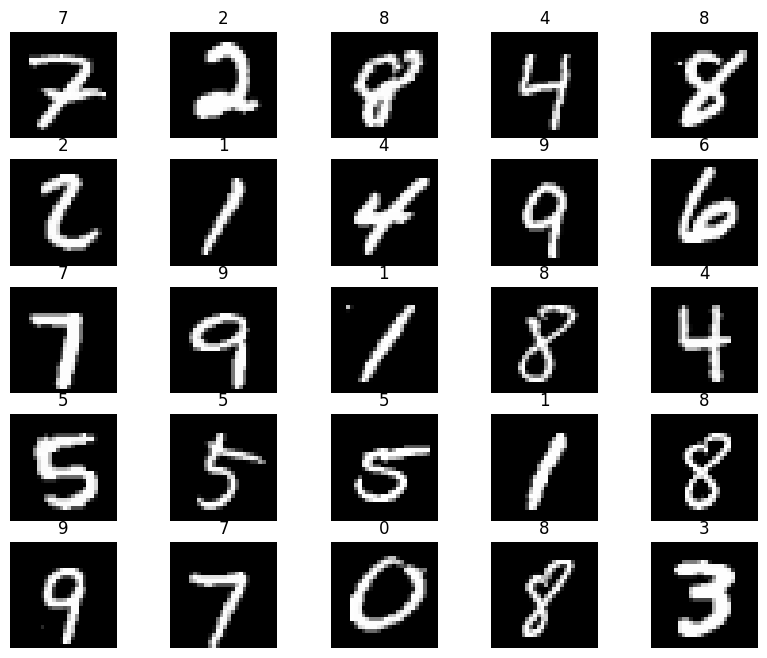

In [5]:
# Visualize một số sample
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Khởi tạo hyperparameters và dataloader

In [21]:
# Hyperparameters
# Hyperparameters
input_dim = 28  # Example: number of features per timestep
seq_length = 100  # Example: number of timesteps in each sequence
layer_dim = 1  # Number of hidden layers
hidden_dim = 256  # Number of hidden units
output_dim = 10  # Example: number of output classes
batch_size = 128
num_epochs = 1  # Optional: number of epochs
checkpoint = 'model.pth'  # Path to save the model checkpoint


In [22]:
# Load dữ liệu vào batch
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

### BiRNN Model


In [23]:
class BiRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(BiRNNModel, self).__init__()

        # Thiết lập số chiều của tầng ẩn
        self.hidden_dim = hidden_dim

        # Thiết lập số layers
        self.layer_dim = layer_dim

        # RNN layer (set bidirectional=True and batch_first=True)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)

        # Readout layer (since BiRNN is bidirectional, hidden_dim*2 is used)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):

        # Khởi tạo hidden state
        h0 = Variable(torch.zeros(2 * self.layer_dim, x.size(0), self.hidden_dim)).to(device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_dim*2)

        # Decode trạng thái ẩn của timestep cuối cùng
        out = self.fc(out[:, -1, :])
        return out


In [27]:
# Tạo một instance lớp BiRNNModel và load vào GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model and move to GPU
model = BiRNNModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)

# Set the model to evaluation mode
model.eval()


BiRNNModel(
  (rnn): RNN(28, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

## **Training phase**

In [28]:
# Loss và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
# Loop for each epoch
for epoch in range(1, num_epochs+1):

    # Quá trình training
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.reshape(-1, 28, 28)
        data, target = data.to(device), target.to(device)

        # Clear gradients for this training step
        optimizer.zero_grad()
        output = model(data)

        # Backpropagation, compute gradients
        loss = criterion(output, target)
        loss.backward()

        # Apply gradients
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch {}: [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    # Quá trình testing
    model.eval()
    test_loss = 0
    correct = 0
    best_val_loss = 999
    # Set no grad cho quá trình testing
    with torch.no_grad():
        for data, target in test_loader:
            data = data.reshape(-1, 28, 28)
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = F.log_softmax(output, dim=1) # Sử dụng hàm log_sotmax để tính xác suất cho output
            test_loss += criterion(output, target)
            pred = output.argmax(dim = 1, keepdim = True) # Sử dụng hàm argmax để lấy predicted label, chú ý keepdim=True
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if test_loss < best_val_loss:
      best_val_loss = test_loss
      torch.save(model.state_dict(), checkpoint)  # Lưu model path
      print("***********    TEST_ACC = {:.2f}%    ***********".format(correct/100))

Train Epoch 1: [0/60000 (0%)]	Train Loss: 2.324903
Train Epoch 1: [12800/60000 (21%)]	Train Loss: 1.022953
Train Epoch 1: [25600/60000 (43%)]	Train Loss: 0.595412
Train Epoch 1: [38400/60000 (64%)]	Train Loss: 0.629405
Train Epoch 1: [51200/60000 (85%)]	Train Loss: 0.595757
***********    TEST_ACC = 78.55%    ***********


In [30]:
# Load lại model đã train
model.load_state_dict(torch.load(checkpoint))

# Xem lại thông số của model
model.eval()

<ipython-input-30-afe4814e6ccb>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint))


BiRNNModel(
  (rnn): RNN(28, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

## **Prediction**

In [32]:
import random

# Lấy ra một batch trong tập test
item = iter(test_loader)
data, target = next(item)
data = data.reshape(-1, 28, 28)

# Lấy random index của một phần tử trong batch đó
test_idx = random.choice(range(len(data)))
print(test_idx)

# Lấy một ví dụ trong tập test
data = data[test_idx]
target = target[test_idx]
assert data.shape == (28, 28)

88


In [33]:
# Predict sử dụng model đã train
def plot(data, model):
    data = torch.unsqueeze(data, dim=0) # unsqueeze data
    data = data.to(device)
    output = model(data)
    output = F.log_softmax(output, dim=1) # log softmax, chú ý dim
    pred = output.argmax(dim=1, keepdim=True) # argmax, chú ý keepdim
    print("Predict Number : ", pred[0][0].detach().cpu().numpy())
    data = torch.unsqueeze(data, dim=0) # unsqueeze data
    plt.imshow(data[0][0].detach().cpu().numpy(), cmap='gray')
    plt.show()

Predict Number :  6


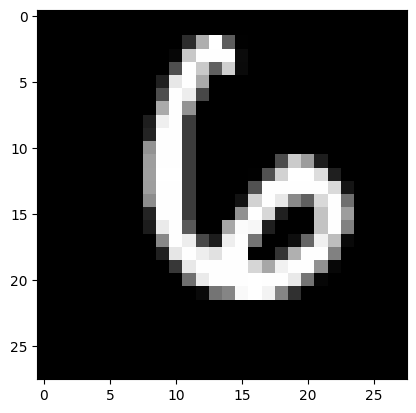

In [34]:
plot(data, model)